### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7db2a7ba9270>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [3]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Downloading: "https://github.com/isl-org/MiDa

Move model to GPU if available

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

Load transforms to resize and normalize the image for large or small model

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

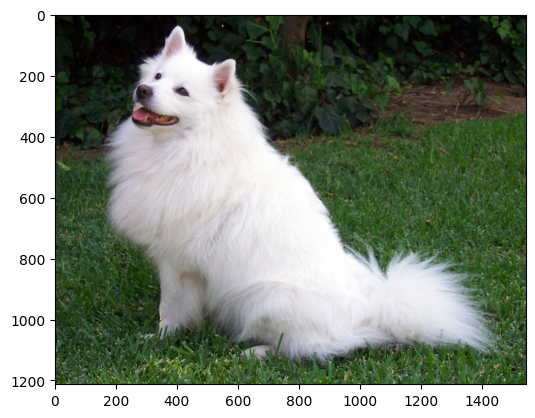

In [25]:
img = cv2.imread("/content/dog.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)
plt.imshow(img)

Predict and resize to original resolution

In [7]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

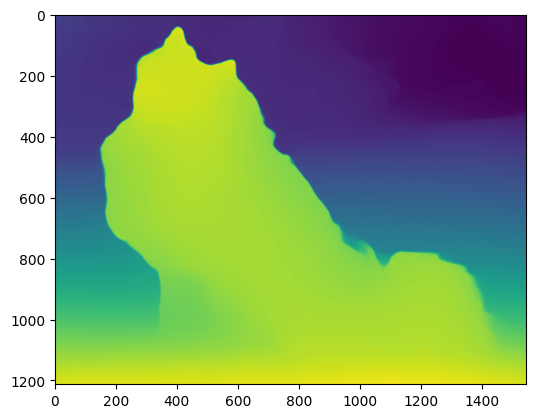

In [8]:
plt.imshow(output)
# plt.show()

In [16]:
depth_8bit = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, thres = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#print(thresholded)
thres.shape

(1213, 1546)

In [17]:
mask = thres > 0

In [20]:
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [21]:
output.shape

(1213, 1546)

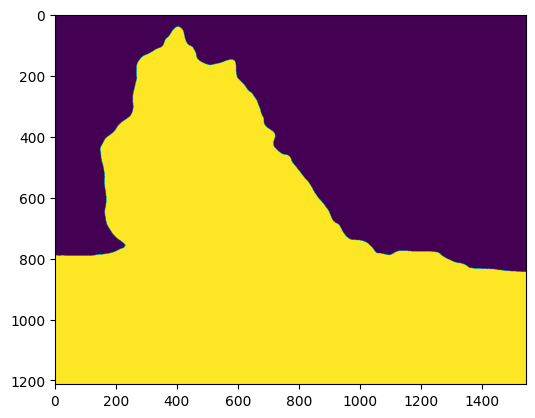

In [95]:
plt.imshow(mask)

In [22]:
import numpy as np

In [23]:
mask = mask.astype(np.bool)
invalid_value = 0
# Apply the mask to the depth map using element-wise multiplication
masked_depth = np.where(mask, output, invalid_value)



<ipython-input-23-aa121f080240>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)


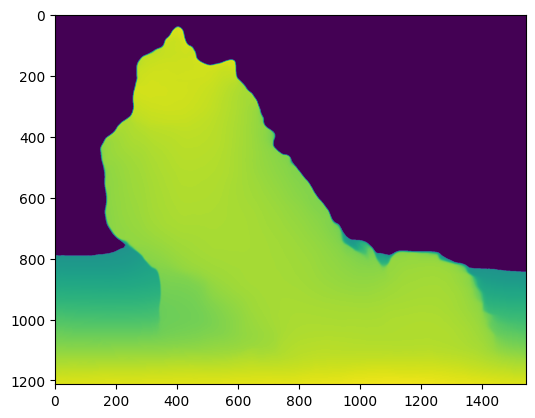

In [24]:
plt.imshow(masked_depth)

In [27]:
from sklearn.cluster import KMeans

In [104]:
depth_values = output.flatten().reshape(-1, 1)

# Perform K-Means clustering to separate the depth values into k clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(depth_values)

# Get the cluster centers
cluster_centers = np.sort(kmeans.cluster_centers_.flatten())

# The threshold is set at the midpoint between the two clusters
threshold = (cluster_centers[0] + 4*cluster_centers[1]) / 5

# Create a binary mask based on the threshold
thresholded = (output >= threshold) * 255
thresholded =  thresholded.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


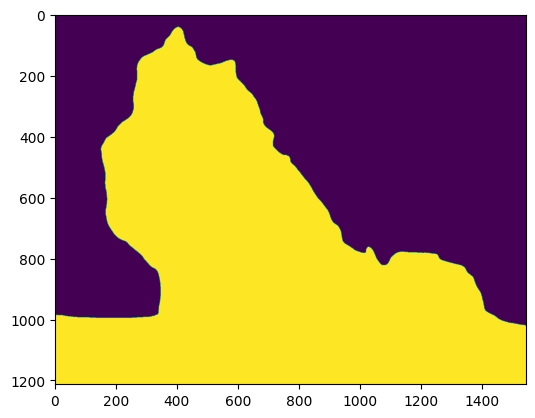

In [105]:
plt.imshow(thresholded)

In [99]:
thresholded

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [49]:
masked_depth2 = np.where(thresholded, output, invalid_value)

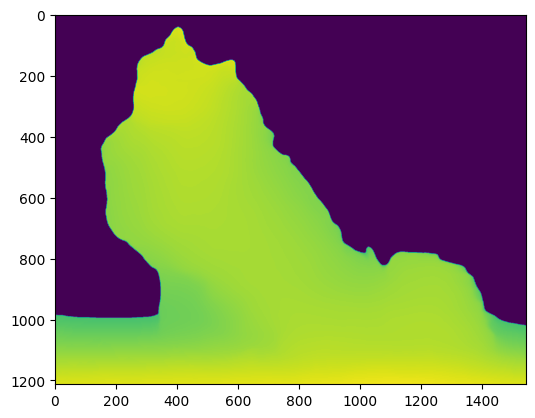

In [50]:
plt.imshow(masked_depth2)

In [51]:
mask2 = output >= threshold

In [52]:
masked_depth3 = np.where(mask2, output, invalid_value)

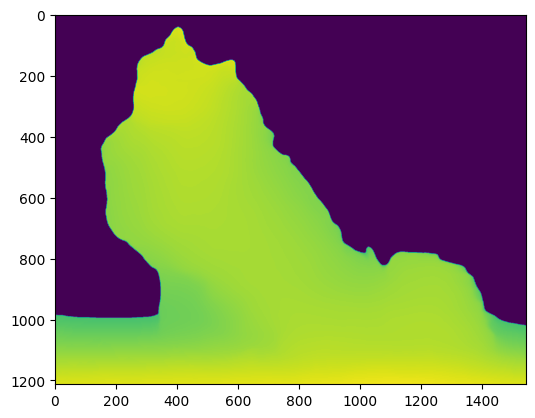

In [106]:
plt.imshow(masked_depth3)

In [115]:
thresholded

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [116]:
bool_thresholded = (thresholded == 255)

In [117]:
bool_thresholded

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [118]:
mask_rgb = np.stack([thresholded]*3 , axis=-1)
rgb_image = img.astype(np.uint8)
rgb_image = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb = img * mask_rgb

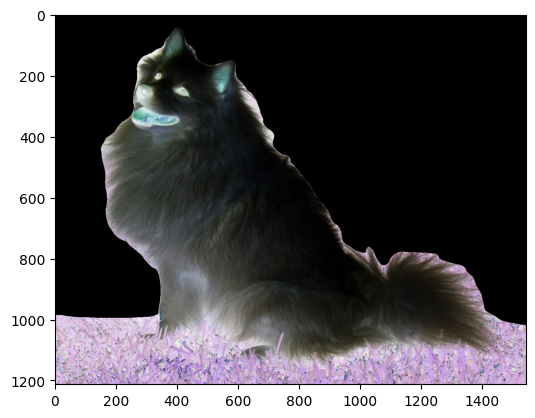

In [119]:
plt.imshow(masked_rgb)

In [120]:
mask_rgb3 = np.stack([bool_thresholded]*3 , axis=-1)
rgb_image3 = img.astype(np.uint8)
rgb_image3 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb3 = img * mask_rgb3

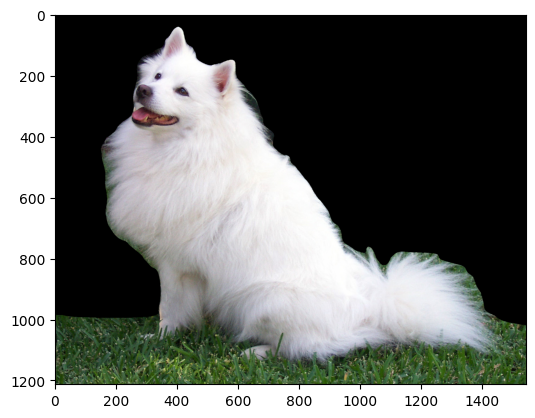

In [121]:
plt.imshow(masked_rgb3)

In [79]:
mask_rgb2 = np.stack([mask]*3 , axis=-1)
#rgb_image2 = img.astype(np.uint8)
#rgb_image2 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb2 = img * mask_rgb2

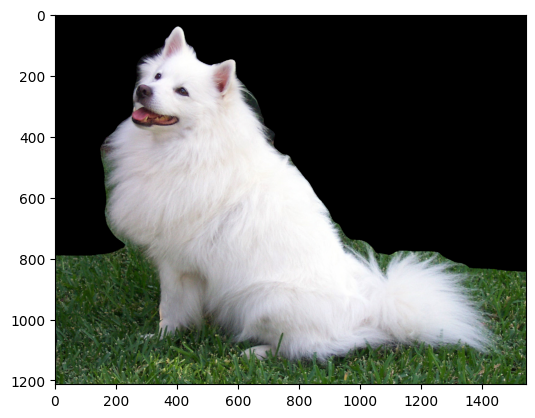

In [80]:
plt.imshow(masked_rgb2)

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}